In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.cluster import KMeans

In [2]:
f = 'contaminantes_2022.csv'
df = pd.read_csv(f,skiprows=10,index_col=0,parse_dates=True)
df

,id_station,id_parameter,value,unit
date,,,,
01/01/2022 01:00,ACO,CO,1.1,15
01/01/2022 01:00,ACO,NO,10.0,1
01/01/2022 01:00,ACO,NO2,39.0,1
01/01/2022 01:00,ACO,NOX,50.0,1
01/01/2022 01:00,ACO,O3,3.0,1
...,...,...,...,...
31/05/2022 24:00,SAC,NO2,9.0,1
31/05/2022 24:00,SAC,NOX,10.0,1
31/05/2022 24:00,SAC,O3,39.0,1


### Obtener estación con menores datos faltantes

In [3]:
datos_agrupados = df.groupby("id_station") # Agrupa los datos que sean iguales en id_station
Valores_nulos = datos_agrupados["value"].apply(lambda x: x.isnull().sum()) # Suma los valores nulos 

Estacion = Valores_nulos.idxmin()
Estacion

'BJU'

In [4]:
# Filtrar los datos para la estación "BJU" y el parámetro "CO"
df_BJU = df.loc[(df['id_station'] == 'BJU') & (df['id_parameter'] == 'CO')]

# Rellenar valores faltantes con el promedio del dato anterior y el dato siguiente
df_BJU = df_BJU.fillna(method='bfill').fillna(method='ffill')

df_BJU

,id_station,id_parameter,value,unit
date,,,,
01/01/2022 01:00,BJU,CO,0.8,15
01/01/2022 02:00,BJU,CO,0.9,15
01/01/2022 03:00,BJU,CO,0.7,15
01/01/2022 04:00,BJU,CO,0.8,15
01/01/2022 05:00,BJU,CO,1.2,15
...,...,...,...,...
31/05/2022 20:00,BJU,CO,0.4,15
31/05/2022 21:00,BJU,CO,0.2,15
31/05/2022 22:00,BJU,CO,0.4,15


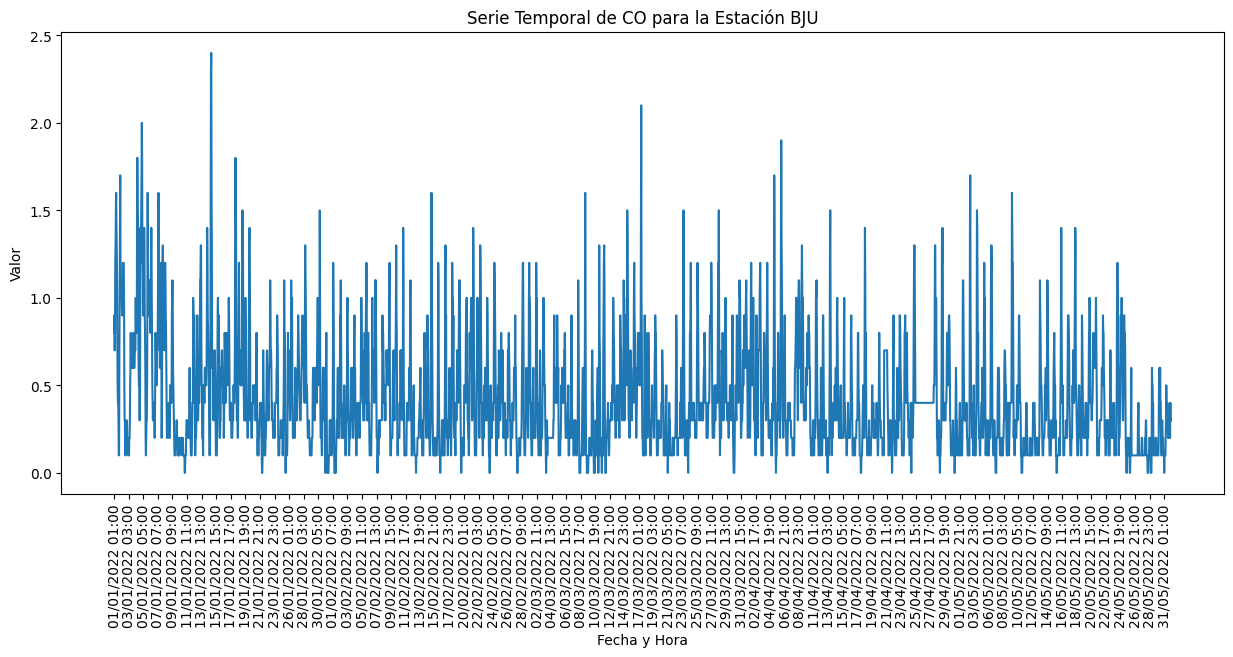

In [5]:
fig = plt.figure(figsize=(15, 6)) 

plt.plot(df_BJU['value'])
plt.xlabel('Fecha y Hora')
plt.ylabel('Valor')
plt.title('Serie Temporal de CO para la Estación BJU')

# Ajustar los xticks
intervalo = 50  
xticks_indices = range(0, len(df_BJU.index), intervalo)  # Índices de los xticks seleccionados
xticks_labels = df_BJU.index[xticks_indices]  # Etiquetas de los xticks seleccionados
plt.xticks(rotation=90, ticks=xticks_indices, labels=xticks_labels)  # Rotar y establecer los xticks seleccionados

plt.show()

# Calculo de horas anomalas

### Unidad tipificada

In [6]:
# Calcular z-scores manualmente
mean = df_BJU['value'].mean()
std = df_BJU['value'].std()
z_scores = (df_BJU['value'] - mean) / std

mean_z = np.mean(z_scores)
std_z = np.std(z_scores)

threshold = 2 * std_z  # Umbral para considerar valores anómalos

# Obtener índices de horas anómalas
horas_anomalas = df_BJU.index[np.abs(z_scores) > threshold]

# Crear un nuevo DataFrame con las horas anómalas
df_anomalas = df_BJU.loc[horas_anomalas]

df_anomalas

,id_station,id_parameter,value,unit
date,,,,
01/01/2022 05:00,BJU,CO,1.2,15
01/01/2022 06:00,BJU,CO,1.3,15
01/01/2022 07:00,BJU,CO,1.5,15
01/01/2022 08:00,BJU,CO,1.6,15
01/01/2022 09:00,BJU,CO,1.4,15
...,...,...,...,...
16/05/2022 08:00,BJU,CO,1.4,15
18/05/2022 08:00,BJU,CO,1.4,15
18/05/2022 09:00,BJU,CO,1.3,15


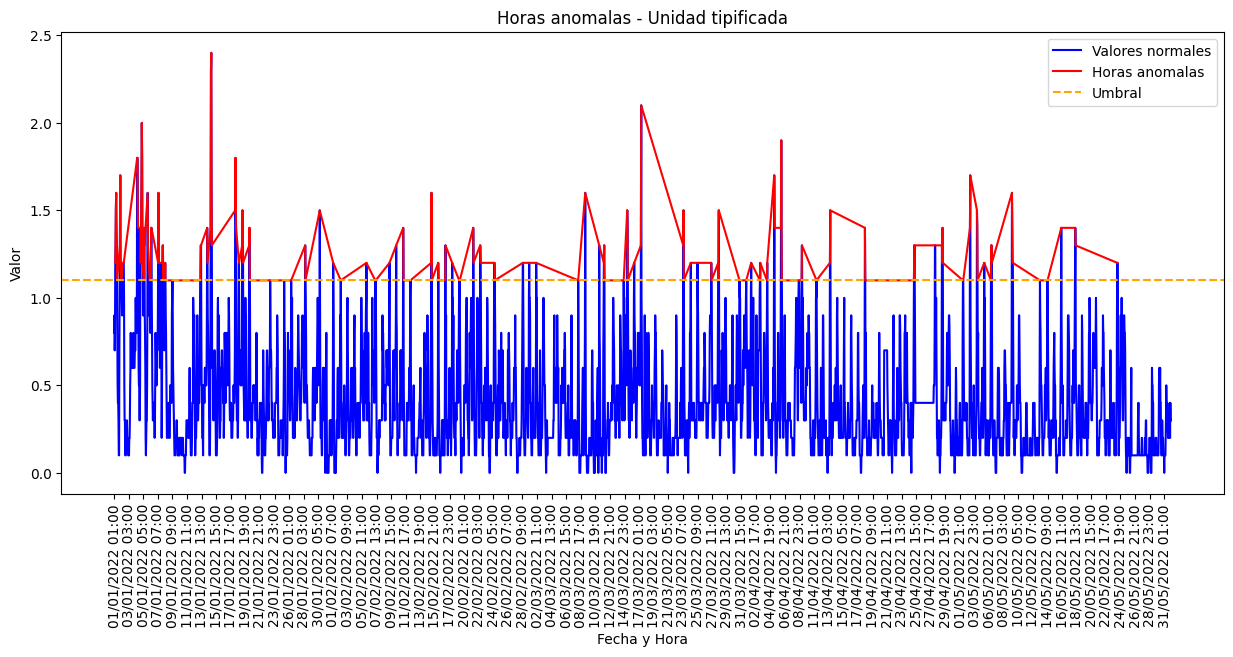

In [7]:
fig = plt.figure(figsize=(15, 6))

# Graficar los valores normales
plt.plot(df_BJU['value'], color='blue', label='Valores normales')
plt.plot(df_anomalas['value'], color='red', label='Horas anomalas')

# Dibujar una línea divisoria en el umbral (threshold)
plt.axhline(y=df_anomalas['value'].min(), color='orange', linestyle='--', label='Umbral')

plt.xlabel('Fecha y Hora')
plt.ylabel('Valor')
plt.title('Horas anomalas - Unidad tipificada')

# Ajustar los xticks
intervalo = 50
xticks_indices = range(0, len(df_BJU.index), intervalo)
xticks_labels = df_BJU.index[xticks_indices]
plt.xticks(rotation=90, ticks=xticks_indices, labels=xticks_labels)

plt.legend()  # Mostrar la leyenda

plt.show()

### Unidad tipificada modificada

In [8]:
# Calcular z-scores manualmente utilizando la unidad tipificada modificada
median = df_BJU['value'].median()
mad = np.median(np.abs(df_BJU['value'] - median))
z_scores_mod = 0.6745 * (df_BJU['value'] - median) / mad

mean_z_mod = np.mean(z_scores_mod)
std_z_mod = np.std(z_scores_mod)

threshold_mod = 2 * std_z_mod  # Umbral para considerar valores anómalos

# Obtener índices de horas anómalas utilizando la unidad tipificada modificada
horas_anomalas_mod = df_BJU.index[np.abs(z_scores_mod) > threshold_mod]

horas_anomalas_mod

# Crear un nuevo DataFrame con las horas anómalas
df_anomalas_mod = df_BJU.loc[horas_anomalas_mod]

df_anomalas_mod

,id_station,id_parameter,value,unit
date,,,,
01/01/2022 05:00,BJU,CO,1.2,15
01/01/2022 06:00,BJU,CO,1.3,15
01/01/2022 07:00,BJU,CO,1.5,15
01/01/2022 08:00,BJU,CO,1.6,15
01/01/2022 09:00,BJU,CO,1.4,15
...,...,...,...,...
21/05/2022 07:00,BJU,CO,1.0,15
24/05/2022 08:00,BJU,CO,1.2,15
24/05/2022 09:00,BJU,CO,1.2,15


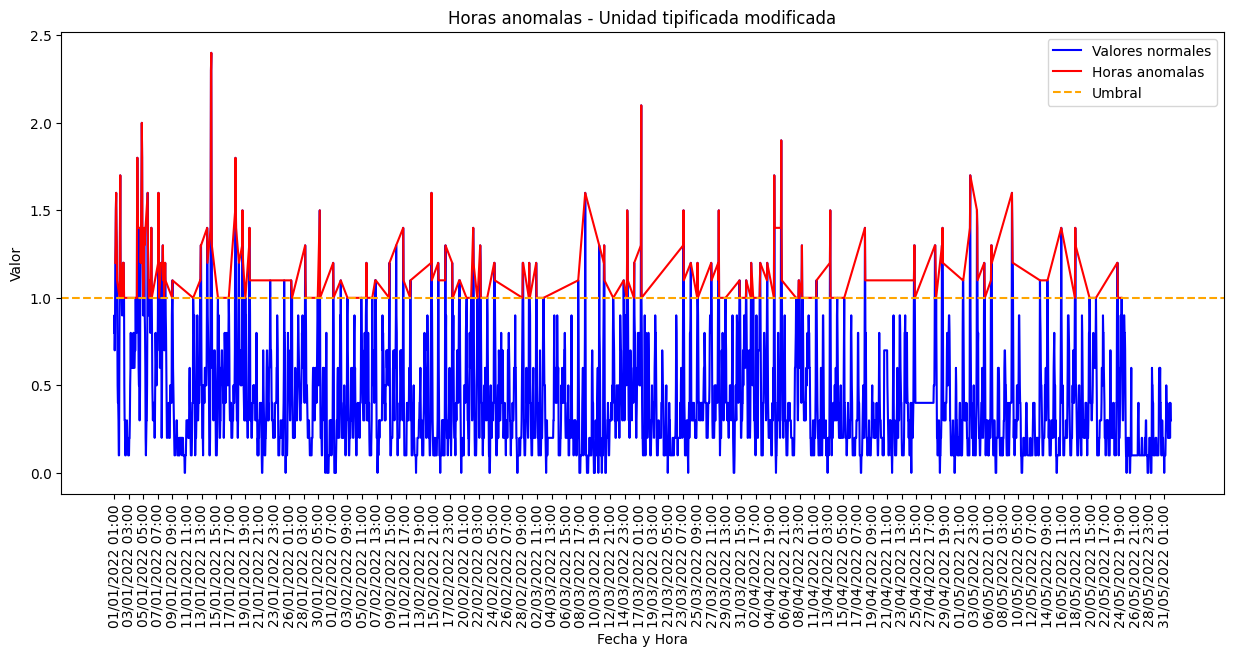

In [9]:
fig = plt.figure(figsize=(15, 6))

# Graficar los valores normales
plt.plot(df_BJU['value'], color='blue', label='Valores normales')
plt.plot(df_anomalas_mod['value'], color='red', label='Horas anomalas')

# Dibujar una línea divisoria en el umbral (threshold)
plt.axhline(y=df_anomalas_mod['value'].min(), color='orange', linestyle='--', label='Umbral')

plt.xlabel('Fecha y Hora')
plt.ylabel('Valor')
plt.title('Horas anomalas - Unidad tipificada modificada')

# Ajustar los xticks
intervalo = 50
xticks_indices = range(0, len(df_BJU.index), intervalo)
xticks_labels = df_BJU.index[xticks_indices]
plt.xticks(rotation=90, ticks=xticks_indices, labels=xticks_labels)

plt.legend()  # Mostrar la leyenda

plt.show()

### K-medias

C:\Users\landa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\landa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\landa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

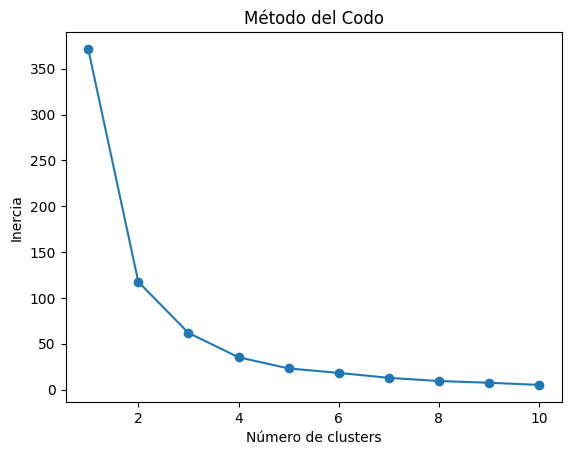

In [10]:
# Obtener los valores de la columna 'value'
values = df_BJU['value'].values.reshape(-1, 1)

# Lista para almacenar las inercias
inertias = []

# Rango de valores para probar el número de clusters
k_values = range(1, 11)

# Calcular las inercias para diferentes valores de k
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(values)
    inertias.append(kmeans.inertia_)


# Graficar la curva de la inercia versus el número de clusters
plt.plot(k_values, inertias, 'o-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

In [11]:
# Obtener el valor óptimo de n_clusters basado en el punto de codo
n_clusters = 4  # Valor óptimo seleccionado

# Instanciar el objeto KMeans con el número de clusters óptimo
kmeans = KMeans(n_clusters=n_clusters)

# Ajustar el modelo óptimo a los datos
kmeans.fit(values)

# Obtener las distancias al centroide del cluster más cercano
distancias_centroides = kmeans.transform(values)
distancias_minimas = np.min(distancias_centroides, axis=1)

# Calcular el threshold utilizando el percentil 95 de las distancias mínimas
threshold = np.percentile(distancias_minimas, 95)

# Obtener los índices de las horas anómalas
horas_anomalas_kmeans = df_BJU.index[distancias_minimas > threshold]

# Crear un nuevo DataFrame con las horas anómalas
df_anomalas_kmeans = df_BJU.loc[horas_anomalas_kmeans]

df_anomalas_kmeans

C:\Users\landa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id_station,id_parameter,value,unit
date,,,,
01/01/2022 07:00,BJU,CO,1.5,15
01/01/2022 08:00,BJU,CO,1.6,15
01/01/2022 09:00,BJU,CO,1.4,15
01/01/2022 20:00,BJU,CO,1.0,15
01/01/2022 22:00,BJU,CO,1.7,15
...,...,...,...,...
18/05/2022 08:00,BJU,CO,1.4,15
20/05/2022 09:00,BJU,CO,1.0,15
21/05/2022 07:00,BJU,CO,1.0,15


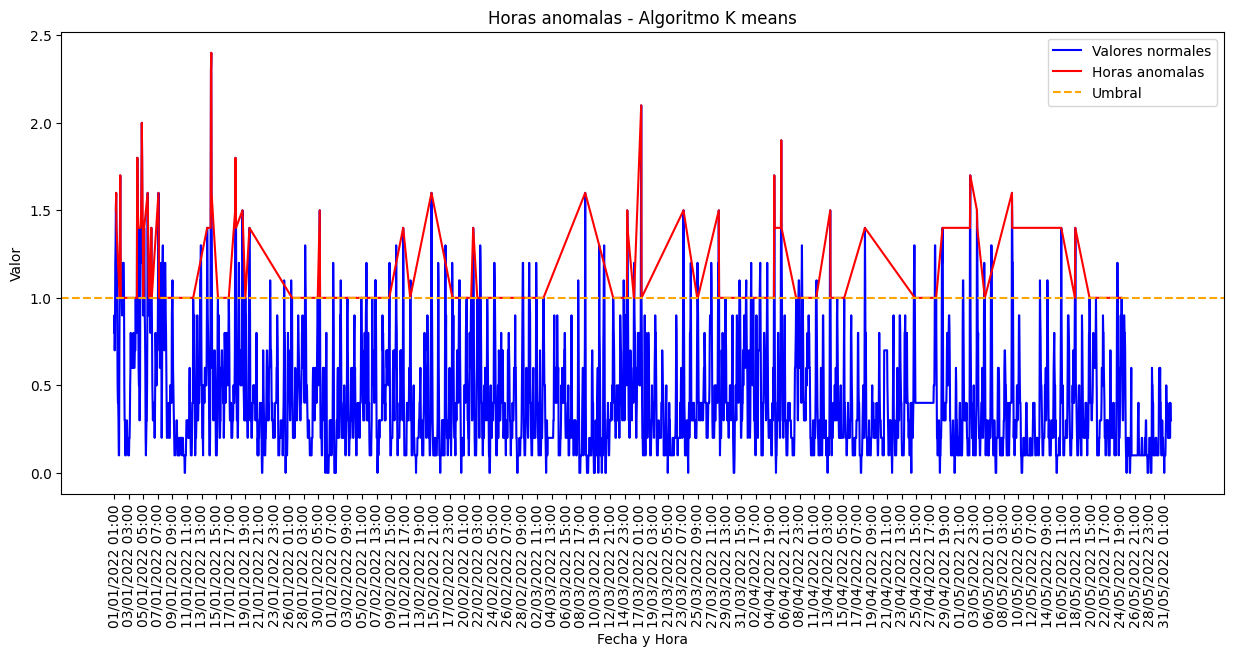

In [12]:
fig = plt.figure(figsize=(15, 6))

# Graficar los valores normales
plt.plot(df_BJU['value'], color='blue', label='Valores normales')
plt.plot(df_anomalas_kmeans['value'], color='red', label='Horas anomalas')

# Dibujar una línea divisoria en el umbral (threshold)
plt.axhline(y=df_anomalas_kmeans['value'].min(), color='orange', linestyle='--', label='Umbral')

plt.xlabel('Fecha y Hora')
plt.ylabel('Valor')
plt.title('Horas anomalas - Algoritmo K means')

# Ajustar los xticks
intervalo = 50
xticks_indices = range(0, len(df_BJU.index), intervalo)
xticks_labels = df_BJU.index[xticks_indices]
plt.xticks(rotation=90, ticks=xticks_indices, labels=xticks_labels)

plt.legend()  # Mostrar la leyenda

plt.show()